# Load catalogue

I'm in the folder that contains the GitHub code from https://github.com/Palomajol/SolarJets-1/tree/SolarJets-Results for this notebook. I also followed the installation notes in the README of the repo and created the conda environment solarjethunterenv to be used for this notebook. More details are found in the other notebook: From SJH catalogue to ML dataset

In [1]:
# to read the catalogue
from utils.Jet_class import json_export_list, json_import_list, csv_import_list, csv_export_list
#import numpy as np 
#from astropy.io import ascii
#import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'utils.workflow_shortend'

In [720]:
# divers
from astropy.coordinates import Angle
import glob
import math

In [735]:
# to update some database
#import numpy as np
import pickle

In [513]:
# to download the data
import os

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.visualization import ImageNormalize, SqrtStretch

import sunpy.coordinates  # NOQA
import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a

In [518]:
jsoc_email = "sophie.musset@esa.int"

In [2]:
#json_file = 'exports/Jet_clusters_3.0_2.0.paperID.json'
#json_file = 'exports/Jet_clusters_3.0_2.0_paperID_cluster_xy.json'
json_file = 'exports/Jet_clusters_3.0_2.0_paperID_cluster_xy_v2.json'

In [3]:
Jet_clusters=json_import_list(json_file)

The 881 JetCluster objects are imported from exports/Jet_clusters_3.0_2.0_paperID_cluster_xy_v2.json.


In [4]:
# Here we have the same format as for the CSV file information
sjh_identifier = np.array([Jet_clusters[i].ID for i in range(len(Jet_clusters))], dtype=str)

# date: Observation time of the start of the jet (format YYYY-MM-DDThh:mm:ss)
Cluster_date = np.array([Jet_clusters[i].obs_time for i in range(len(Jet_clusters))], dtype='datetime64')
# duration of the jet (minutes)
stat_dur = np.array([Jet_clusters[i].Duration for i in range(len(Jet_clusters))], dtype=float)

Cluster_SOL = np.array([Jet_clusters[i].SOL for i in range(len(Jet_clusters))], dtype=str)

stat_Bx = np.array([Jet_clusters[i].Bx for i in range(len(Jet_clusters))], dtype=float)
stat_By = np.array([Jet_clusters[i].By for i in range(len(Jet_clusters))], dtype=float)
stat_Lon = np.array([Jet_clusters[i].Lon for i in range(len(Jet_clusters))], dtype=float)
stat_Lat = np.array([Jet_clusters[i].Lat for i in range(len(Jet_clusters))], dtype=float)
stat_H = np.array([Jet_clusters[i].Max_Height for i in range(len(Jet_clusters))], dtype=float)
stat_W = np.array([Jet_clusters[i].Width for i in range(len(Jet_clusters))], dtype=float)
stat_vel = np.array([Jet_clusters[i].Velocity for i in range(len(Jet_clusters))], dtype=float)
stat_sigma = np.array([Jet_clusters[i].sigma for i in range(len(Jet_clusters))], dtype=float)
std_H = np.array([Jet_clusters[i].std_maxH for i in range(len(Jet_clusters))], dtype=float)
std_W = np.array([Jet_clusters[i].std_W for i in range(len(Jet_clusters))], dtype=float)
std_Bx = np.array([Jet_clusters[i].std_Bx for i in range(len(Jet_clusters))], dtype=float)
std_By = np.array([Jet_clusters[i].std_By for i in range(len(Jet_clusters))], dtype=float)
flags = np.array([Jet_clusters[i].flag for i in range(len(Jet_clusters))], dtype=str)
#angle = np.array([Jet_clusters[i].angle for i in range(len(Jet_clusters))], dtype=float)

Define some useful functions

In [743]:
def make_cluster_box(cluster_jet):
    
    ## calculate angle from subjects
    heights = []
    angles = []
    for jet in cluster_jet.jets:
        heights.append(jet.height)
        angles.append(jet.angle)
    jet_box_angle = angles[heights.index(max(heights))]
    jet_box_angle = np.mean(angles)
    
    jet_box = Jet_box([cluster_jet.Bx, cluster_jet.By], cluster_jet.Max_Height, cluster_jet.Width, jet_box_angle)
    return jet_box

In [758]:
def make_subject_box(subject_jet):
    subject_box = Jet_box(subject_jet.solar_start, subject_jet.solar_H, subject_jet.solar_W, subject_jet.angle)
    return subject_box

In [741]:
def plot_all_subject_boxes_and_average_box(jet_cluster, cluster_box, aia_map):
    
    fig = plt.figure()
    ax = fig.add_subplot(projection=aia_map)
    image = aia_map.plot(axes=ax)

    for subject in jet_cluster.jets:
        subject_box = Jet_box(subject.solar_start, subject.solar_H, subject.solar_W, subject.angle)
        for line in subject_box.lines_to_plot():
            ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
            color='white', linewidth=0.7, linestyle='dotted',
            transform=ax.get_transform("world"))

    for line in cluster_box.lines_to_plot():
        ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
            color='white',
            transform=ax.get_transform("world"))

    plt.show()

In [734]:
class Jet_box:
    # can be used for any box defined with solar coordinates
    
    def __init__(self, base, height, width, angle):
        self.base = base*u.arcsec
        self.height = height*u.arcsec
        self.width = width*u.arcsec
        self.angle = Angle(angle-math.pi/2, u.radian) 
        
    def area(self):
        return self.height*self.width
        
    def center(self):
        center_coordinates = [0.,0.]
        center_coordinates[0] = self.base[0] + self.height/2.*np.cos(self.angle.radian) 
        center_coordinates[1] = self.base[1] + self.height/2.*np.sin(self.angle.radian) 
        return center_coordinates
    
    def corners(self):
        x1 = self.base[0] - 0.5*self.width*np.sin(self.angle.radian)
        x2 = self.base[0] + 0.5*self.width*np.sin(self.angle.radian)
        y1 = self.base[1] + 0.5*self.width*np.cos(self.angle.radian)
        y2 = self.base[1] - 0.5*self.width*np.cos(self.angle.radian)
        dx = self.height*np.cos(self.angle.radian)
        dy = self.height*np.sin(self.angle.radian)
        dxp = self.width*np.sin(self.angle.radian)
        dyp = self.width*np.cos(self.angle.radian)
        x3 = x1+dx
        y3 = y1+dy
        x4 = x2+dx
        y4 = y2+dy
        return [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    
    def lines_to_plot(self):
        corners = self.corners()
        line1x = np.array([corners[0][0].value, corners[2][0].value])
        line1y = np.array([corners[0][1].value, corners[2][1].value])
        line2x = np.array([corners[1][0].value, corners[3][0].value])
        line2y = np.array([corners[1][1].value, corners[3][1].value])
        line3x = np.array([corners[0][0].value, corners[1][0].value])
        line3y = np.array([corners[0][1].value, corners[1][1].value])
        line4x = np.array([corners[2][0].value, corners[3][0].value])
        line4y = np.array([corners[2][1].value, corners[3][1].value])
        return [[line1x, line1y], [line2x, line2y], [line3x, line3y], [line4x, line4y]]

# Choose one jet and get data

## Selection of a jet and creation of path, box, etc

In [766]:
### jetid = 10 ### not to bad
jetid = 508

print(sjh_identifier[jetid])
selected_jet = Jet_clusters[jetid]
data_path = 'C://Users//sophie.musset//data//sjh_cutouts//'+selected_jet.ID
jet_box = make_cluster_box(selected_jet)

sjh_2015-09-22T21_1


In [765]:
jet_start_time = selected_jet.obs_time
jet_end_time = selected_jet.obs_time + np.timedelta64(int(selected_jet.Duration*60), 's')
print(jet_start_time)
print(jet_end_time)

2015-09-22T21:56:06.000000
2015-09-22T22:27:42.000000


## Check if data for this jet has been downloaded: 
see notebook 'jet_data_keeptrack'

In [707]:
database_name = "jet_data_keeptrack.p"

In [708]:
jet_data_database = pickle.load( open( database_name, "rb" ) )

In [709]:
jet_data_database["AIA304_downloaded"][np.where(jet_data_database["jet_id"] == sjh_identifier[jetid] )]

array([ True])

## If need to download the data

Check if directory to download data exists, if not, create it

In [514]:
if not os.path.exists(data_path): os.mkdir(data_path)

Calculating the coordinates of the FOV for the cutout

In [768]:
print(jet_box.base, jet_box.height)
cutout_half_side = 60 if jet_box.height.value < 60 else jet_box.height.value + 20
print(cutout_half_side)
x1 = jet_box.base[0].value - cutout_half_side
x2 = jet_box.base[0].value + cutout_half_side
y1 = jet_box.base[1].value - cutout_half_side
y2 = jet_box.base[1].value + cutout_half_side

[ 922.16766667 -294.40316667] arcsec 196.60270234663622 arcsec
216.60270234663622


In [516]:
bottom_left = SkyCoord(x1*u.arcsec, y1*u.arcsec, obstime=jet_start_time, observer="earth", frame="helioprojective")
top_right = SkyCoord(x2*u.arcsec, y2*u.arcsec, obstime=jet_start_time, observer="earth", frame="helioprojective")

In [517]:
cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=False)

In [519]:
query = Fido.search(
    a.Time(jet_start_time, jet_end_time),
    a.Wavelength(304*u.angstrom),
    a.Sample(24*u.s),
    a.jsoc.Series.aia_lev1_euv_12s,
    a.jsoc.Notify(jsoc_email),
    a.jsoc.Segment.image,
    cutout,
)
print(query)

Results from 1 Provider:

80 Results from the JSOCClient:
Source: http://jsoc.stanford.edu

       T_REC         TELESCOP INSTRUME WAVELNTH CAR_ROT
-------------------- -------- -------- -------- -------
2015-09-22T21:56:00Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:56:24Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:56:48Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:57:12Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:57:36Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:58:00Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:58:24Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:58:48Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:59:12Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:59:36Z  SDO/AIA    AIA_4      304    2168
                 ...      ...      ...      ...     ...
2015-09-22T22:23:36Z  SDO/AIA    AIA_4      304    2168
2015-09-22T22:24:00Z  SDO/AIA    AIA_4      304    2168
2015-09-22T22:24:24Z  SDO/AIA    AIA_4      304    2168
2015-09-22T2

In [520]:
files = Fido.fetch(query, overwrite=False, path=data_path)
files.sort()

Export request pending. [id=JSOC_20240118_2090, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20240118_2090, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240118_2090, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240118_2090, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240118_2090, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240118_2090, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240118_2090, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240118_2090, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240118_2090, status=1]
Waiting for 5 seconds...
80 URLs found for download. Full request totalling 22MB


Files Downloaded:   0%|                                                                       | 0/80 [00:00<?, ?file/s]
aia.lev1_euv_12s.2015-09-22T215600Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T215600Z.304.image.fits:   0%|                          | 1.02k/288k [00:00<04:13, 1.13kB/s]
aia.lev1_euv_12s.2015-09-22T215600Z.304.image.fits:  12%|███                       | 33.4k/288k [00:01<00:06, 42.4kB/s]
aia.lev1_euv_12s.2015-09-22T215600Z.304.image.fits:  29%|███████▋                   | 82.6k/288k [00:01<00:01, 104kB/s]
aia.lev1_euv_12s.2015-09-22T215600Z.304.image.fits:  69%|███████████████████▏        | 197k/288k [00:01<00:00, 259kB/s]
Files Downloaded:   1%|▊                                                              | 1/80 [00:02<02:57,  2.25s/file]
aia.lev1_euv_12s.2015-09-22T215624Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T215624Z.304.

Files Downloaded:  14%|████████▌                                                     | 11/80 [00:20<02:04,  1.80s/file]
aia.lev1_euv_12s.2015-09-22T220024Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T220024Z.304.image.fits:   0%|                          | 1.02k/288k [00:00<04:08, 1.15kB/s]
aia.lev1_euv_12s.2015-09-22T220024Z.304.image.fits:  12%|███                       | 33.4k/288k [00:01<00:05, 43.3kB/s]
aia.lev1_euv_12s.2015-09-22T220024Z.304.image.fits:  29%|███████▋                   | 82.6k/288k [00:01<00:01, 106kB/s]
aia.lev1_euv_12s.2015-09-22T220024Z.304.image.fits:  69%|███████████████████▏        | 197k/288k [00:01<00:00, 266kB/s]
Files Downloaded:  15%|█████████▎                                                    | 12/80 [00:22<02:02,  1.80s/file]
aia.lev1_euv_12s.2015-09-22T220048Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T220048Z.304.

Files Downloaded:  28%|█████████████████                                             | 22/80 [00:40<01:45,  1.82s/file]
aia.lev1_euv_12s.2015-09-22T220448Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T220448Z.304.image.fits:   0%|                          | 1.02k/288k [00:00<04:15, 1.12kB/s]
aia.lev1_euv_12s.2015-09-22T220448Z.304.image.fits:  12%|███                       | 33.4k/288k [00:01<00:06, 42.1kB/s]
aia.lev1_euv_12s.2015-09-22T220448Z.304.image.fits:  29%|███████▋                   | 82.6k/288k [00:01<00:01, 103kB/s]
aia.lev1_euv_12s.2015-09-22T220448Z.304.image.fits:  69%|███████████████████▏        | 197k/288k [00:01<00:00, 259kB/s]
Files Downloaded:  29%|█████████████████▊                                            | 23/80 [00:42<01:43,  1.82s/file]
aia.lev1_euv_12s.2015-09-22T220512Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T220512Z.304.

Files Downloaded:  41%|█████████████████████████▌                                    | 33/80 [01:00<01:25,  1.83s/file]
aia.lev1_euv_12s.2015-09-22T220912Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T220912Z.304.image.fits:   0%|                          | 1.02k/288k [00:00<04:11, 1.14kB/s]
aia.lev1_euv_12s.2015-09-22T220912Z.304.image.fits:  12%|███                       | 33.4k/288k [00:01<00:05, 42.7kB/s]
aia.lev1_euv_12s.2015-09-22T220912Z.304.image.fits:  29%|███████▋                   | 82.6k/288k [00:01<00:01, 104kB/s]
aia.lev1_euv_12s.2015-09-22T220912Z.304.image.fits:  69%|███████████████████▏        | 197k/288k [00:01<00:00, 260kB/s]
Files Downloaded:  42%|██████████████████████████▎                                   | 34/80 [01:02<01:23,  1.82s/file]
aia.lev1_euv_12s.2015-09-22T220936Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T220936Z.304.

Files Downloaded:  55%|██████████████████████████████████                            | 44/80 [01:20<01:05,  1.82s/file]
aia.lev1_euv_12s.2015-09-22T221336Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T221336Z.304.image.fits:   0%|                          | 1.02k/288k [00:00<04:10, 1.14kB/s]
aia.lev1_euv_12s.2015-09-22T221336Z.304.image.fits:  12%|███                       | 33.4k/288k [00:01<00:05, 43.0kB/s]
aia.lev1_euv_12s.2015-09-22T221336Z.304.image.fits:  29%|███████▋                   | 82.6k/288k [00:01<00:01, 106kB/s]
aia.lev1_euv_12s.2015-09-22T221336Z.304.image.fits:  69%|███████████████████▏        | 197k/288k [00:01<00:00, 265kB/s]
Files Downloaded:  56%|██████████████████████████████████▉                           | 45/80 [01:21<01:03,  1.81s/file]
aia.lev1_euv_12s.2015-09-22T221400Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T221400Z.304.

Files Downloaded:  69%|██████████████████████████████████████████▋                   | 55/80 [01:40<00:45,  1.82s/file]
aia.lev1_euv_12s.2015-09-22T221800Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T221800Z.304.image.fits:   0%|                          | 1.02k/288k [00:00<04:08, 1.15kB/s]
aia.lev1_euv_12s.2015-09-22T221800Z.304.image.fits:  12%|███                       | 33.4k/288k [00:01<00:05, 43.2kB/s]
aia.lev1_euv_12s.2015-09-22T221800Z.304.image.fits:  29%|███████▋                   | 82.6k/288k [00:01<00:01, 106kB/s]
aia.lev1_euv_12s.2015-09-22T221800Z.304.image.fits:  69%|███████████████████▏        | 197k/288k [00:01<00:00, 266kB/s]
Files Downloaded:  70%|███████████████████████████████████████████▍                  | 56/80 [01:42<00:43,  1.82s/file]
aia.lev1_euv_12s.2015-09-22T221824Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T221824Z.304.

Files Downloaded:  82%|███████████████████████████████████████████████████▏          | 66/80 [02:00<00:25,  1.80s/file]
aia.lev1_euv_12s.2015-09-22T222224Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T222224Z.304.image.fits:   0%|                          | 1.02k/288k [00:00<04:12, 1.14kB/s]
aia.lev1_euv_12s.2015-09-22T222224Z.304.image.fits:  12%|███                       | 33.4k/288k [00:01<00:06, 42.4kB/s]
aia.lev1_euv_12s.2015-09-22T222224Z.304.image.fits:  29%|███████▋                   | 82.6k/288k [00:01<00:01, 104kB/s]
aia.lev1_euv_12s.2015-09-22T222224Z.304.image.fits:  69%|███████████████████▏        | 197k/288k [00:01<00:00, 259kB/s]
Files Downloaded:  84%|███████████████████████████████████████████████████▉          | 67/80 [02:01<00:23,  1.81s/file]
aia.lev1_euv_12s.2015-09-22T222248Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T222248Z.304.

Files Downloaded:  96%|███████████████████████████████████████████████████████████▋  | 77/80 [02:19<00:05,  1.79s/file]
aia.lev1_euv_12s.2015-09-22T222648Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T222648Z.304.image.fits:   0%|                          | 1.02k/288k [00:00<04:14, 1.13kB/s]
aia.lev1_euv_12s.2015-09-22T222648Z.304.image.fits:  12%|███                       | 33.4k/288k [00:01<00:06, 42.3kB/s]
aia.lev1_euv_12s.2015-09-22T222648Z.304.image.fits:  29%|███████▋                   | 82.6k/288k [00:01<00:01, 104kB/s]
aia.lev1_euv_12s.2015-09-22T222648Z.304.image.fits:  69%|███████████████████▏        | 197k/288k [00:01<00:00, 259kB/s]
Files Downloaded:  98%|████████████████████████████████████████████████████████████▍ | 78/80 [02:21<00:03,  1.79s/file]
aia.lev1_euv_12s.2015-09-22T222712Z.304.image.fits:   0%|                                   | 0.00/288k [00:00<?, ?B/s]
aia.lev1_euv_12s.2015-09-22T222712Z.304.

Upload the keep track data base and save the data base

In [521]:
jet_data_database["AIA304_downloaded"][np.where(jet_data_database["jet_id"] == sjh_identifier[jetid] )] = 1

In [522]:
pickle.dump(jet_data_database, open(database_name, "wb"))

# Plot jet and base points 

In [710]:
files = glob.glob(data_path+"//aia.lev1_euv_12s.*.304.image.fits")
len(files)

80

In [711]:
aia_map = sunpy.map.Map(files[52])
jet_box.base

<Quantity [ 922.16766667, -294.40316667] arcsec>

In [712]:
jet_base_coord = SkyCoord(jet_box.base[0], jet_box.base[1], 
                                  obstime=aia_map.date, 
                                  observer="earth", 
                                  frame="helioprojective")
jet_base_coord

<SkyCoord (Helioprojective: obstime=2015-09-22T22:16:54.123, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty) in arcsec
    (922.16766667, -294.40316667)>

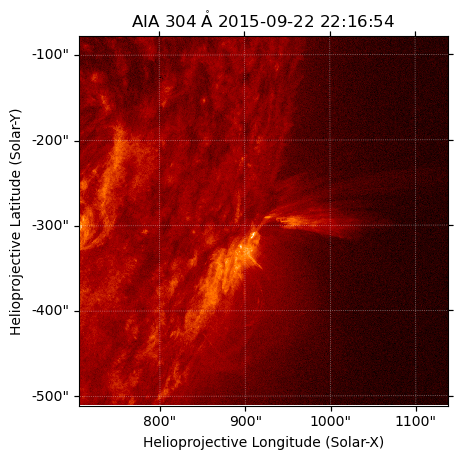

In [713]:
### fig = plt.figure(dpi=150) ### export quality
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)

image = aia_map.plot(axes=ax)

ax.plot_coord(jet_base_coord, marker='o', color='blue') ## will not work if off limb

xx=np.array([jet_box_xc, jet_box_xc+1])
yy=np.array([jet_box_yc, jet_box_yc+1])

plt.show()

# Plot jet in box

In [717]:
rectangle_center_coord = SkyCoord(jet_box.center()[0], jet_box.center()[1], 
                                  obstime=aia_map.date, 
                                  observer="earth", 
                                  frame="helioprojective")

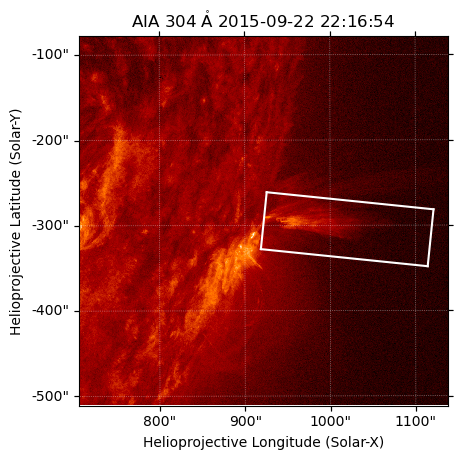

In [739]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

# Note that the coordinates need to be in degrees rather than arcseconds.
for line in jet_box.lines_to_plot():
    ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
            color='white',
            transform=ax.get_transform("world"))

#ax.plot_coord(rectangle_center_coord, marker='o', color='white')
plt.show()

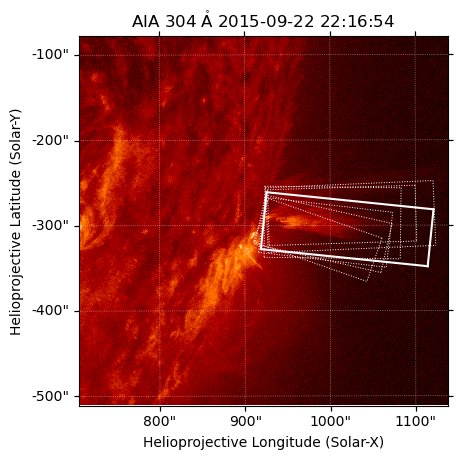

In [742]:
plot_all_subject_boxes_and_average_box(selected_jet, jet_box, aia_map)

In [761]:
Jet_clusters[jetid].jets[5].time

numpy.datetime64('2015-09-22T22:22:06.000000')

In [762]:
subject_box = make_subject_box(Jet_clusters[jetid].jets[2])

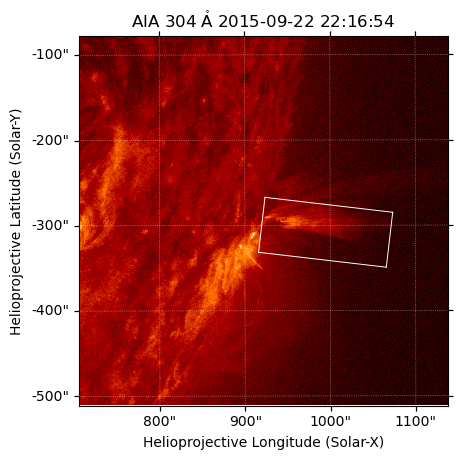

In [763]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

# Note that the coordinates need to be in degrees rather than arcseconds.
for line in subject_box.lines_to_plot():
    ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
            color='white', linewidth=0.7,
            transform=ax.get_transform("world"))
    
plt.show()

Create submap to plot figure to be included in the proposal

In [658]:
top_right = SkyCoord(1115 * u.arcsec, -150 * u.arcsec, frame=aia_map.coordinate_frame)
bottom_left = SkyCoord(800 * u.arcsec, -400 * u.arcsec, frame=aia_map.coordinate_frame)
submap = aia_map.submap(bottom_left, top_right=top_right)

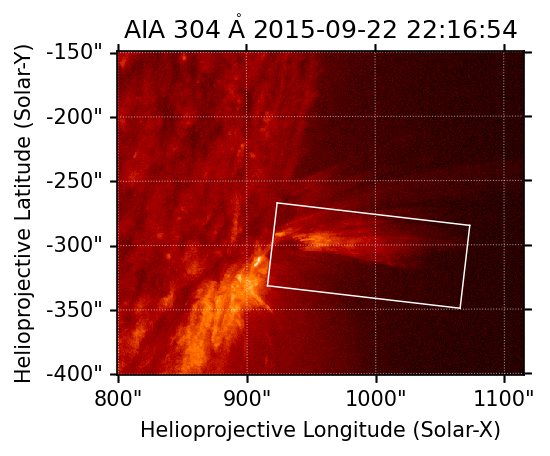

In [764]:
fig = plt.figure(dpi=150, figsize = (3.5, 3.5))
ax = fig.add_subplot(projection=submap)
image = submap.plot(axes=ax)

# Note that the coordinates need to be in degrees rather than arcseconds.
for line in subject_box.lines_to_plot():
    ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
            color='white', linewidth=0.7,
            transform=ax.get_transform("world"))

plt.show()

# Time-distance plot

### Calculate box center

In [769]:
selected_box = subject_box

In [771]:
rectangle_center_coord = SkyCoord(selected_box.center()[0], selected_box.center()[1], 
                                  obstime=jet_start_time, 
                                  observer="earth", 
                                  frame="helioprojective")

### Extract coordinates of the rectangle in pixels

We will extract the center of the box in pixel coordinates, then calculate the width and length of the box in pixels too. In here we are talking about the AIA pixels. We will keep the angle of the box as defined.

In [781]:
from sunpy.coordinates import Helioprojective

In [783]:
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate, only_off_disk=True):
    px, py = aia_map.wcs.world_to_pixel(rectangle_center_coord)
print(px, py)

482.24440683854914 337.77292848987076


In [784]:
aia_pixel_scale = 0.5*(aia_map.scale[0]+aia_map.scale[1])

In [785]:
rectangle_width_inpix = rectangle_width/aia_pixel_scale
rectangle_length_inpix = rectangle_length/aia_pixel_scale

### Get the rotation right

Extract data from map

In [786]:
data_array = aia_map.data

Define rotation angle

In [787]:
rotation_angle = selected_box.angle

Plot data

C:\Users\sophie.musset\AppData\Local\Temp\ipykernel_8040\4155190472.py:4: RuntimeWarning: divide by zero encountered in log
  ax1.imshow(np.log(img), cmap='gray', origin="lower")
C:\Users\sophie.musset\AppData\Local\Temp\ipykernel_8040\4155190472.py:4: RuntimeWarning: invalid value encountered in log
  ax1.imshow(np.log(img), cmap='gray', origin="lower")


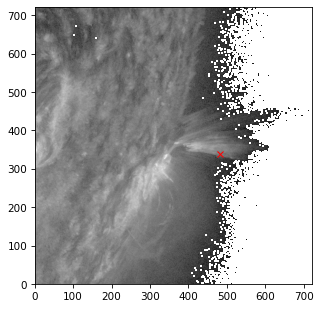

In [788]:
fig = plt.figure(dpi=75)
ax1 = fig.subplots(1, 1)
img = data_array
ax1.imshow(np.log(img), cmap='gray', origin="lower")
ax1.plot(px,py, marker='x',c='red')
plt.show()

Rotate image

In [789]:
from scipy import ndimage, datasets

In [790]:
rotated_data = np.log(ndimage.rotate(data_array, rotation_angle, reshape=True))

C:\Users\sophie.musset\AppData\Local\Temp\ipykernel_8040\2813143265.py:1: RuntimeWarning: divide by zero encountered in log
  rotated_data = np.log(ndimage.rotate(data_array, rotation_angle, reshape=True))
C:\Users\sophie.musset\AppData\Local\Temp\ipykernel_8040\2813143265.py:1: RuntimeWarning: invalid value encountered in log
  rotated_data = np.log(ndimage.rotate(data_array, rotation_angle, reshape=True))


Define a function to do the coordinate transformation between the pixel coordinates in the original data array and the pixel coordinates in the rotated data array, with the `reshape=True` when calling `ndimage.rotate()`

In [824]:
def coordinates_in_rotated_frame(px,py,rotation_angle,array):
    # (px,py) are the coordinates (in pixel coordinates) of a pixel in the array
    # rotation_angle should be provided with units
    # array is the data array before rotation
    
    # extract the width and length of the data array
    Lx = np.shape(array)[1]
    Ly = np.shape(array)[0]

    # calculate polar coordinates before rotation
    center_r = np.sqrt(px*px+py*py)
    center_angle = np.arctan(py/px) * u.rad
    
    # polar coordinate in (intermediary) rotated frame 
    new_center_r = center_r
    new_angle = center_angle - rotation_angle 

    # shift in x and y for the final frame
    if (rotation_angle>=0)&(rotation_angle<=90*u.deg):
        x_shift = 0
        y_shift = Lx*np.sin(rotation_angle)
    if (rotation_angle>90*u.deg)&(rotation_angle<=180*u.deg):
        x_shift = Lx*np.abs(np.cos(rotation_angle))
        y_shift = Lx*np.abs(np.sin(rotation_angle)) + Ly*np.abs(np.cos(rotation_angle))
    if (rotation_angle>=-90*u.deg)&(rotation_angle<0*u.deg):
        x_shift = Ly*np.abs(np.sin(rotation_angle))
        y_shift = 0
    if (rotation_angle>-180*u.deg)&(rotation_angle<-90*u.deg):
        x_shift = Lx*np.abs(np.cos(rotation_angle)) + Ly*np.abs(np.sin(rotation_angle))
        y_shift = Ly*np.abs(np.cos(rotation_angle))
    
    #new coordinates
    new_px = new_center_r*np.cos(new_angle) + x_shift
    new_py = new_center_r*np.sin(new_angle) + y_shift

    return np.array([new_px,new_py])

Calculate new coordinates and use it to plot the rotated array

In [792]:
new_coords = coordinates_in_rotated_frame(px,py,rotation_angle,data_array)

In [793]:
rectangle_xx = new_coords[0] + 0.5*rectangle_length_inpix.value*np.array([-1,1])
rectangle_yy = new_coords[1] + 0.5*rectangle_width_inpix.value*np.array([-1,1])
int(rectangle_xx[0])

360

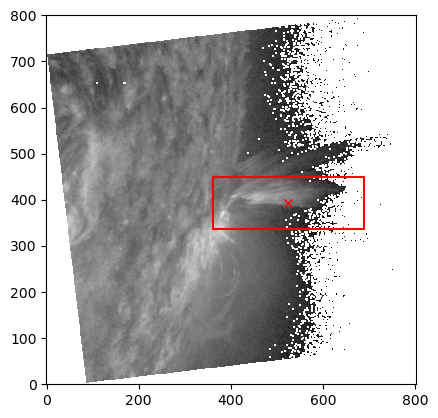

In [794]:
fig = plt.figure(dpi=100)
ax = fig.subplots(1, 1)
ax.imshow(rotated_data, cmap='gray', origin="lower")
ax.plot(new_coords[0],new_coords[1], marker='x',c='red')

ax.plot(rectangle_xx, np.array([rectangle_yy[0],rectangle_yy[0]]),
        color='red')
ax.plot(rectangle_xx, np.array([rectangle_yy[1],rectangle_yy[1]]),
        color='red')
ax.plot(np.array([rectangle_xx[0],rectangle_xx[0]]), rectangle_yy,
        color='red')
ax.plot(np.array([rectangle_xx[1],rectangle_xx[1]]), rectangle_yy,
        color='red')

plt.show()

Select the data in the rectangle and sum everything in the y-direction

In [815]:
in_box = rotated_data[ int(rectangle_yy[0]):int(rectangle_yy[1]), int(rectangle_xx[0]):int(rectangle_xx[1])]
#in_box[np.isnan(in_box)] = 0
in_box[np.isneginf(in_box)] = 0

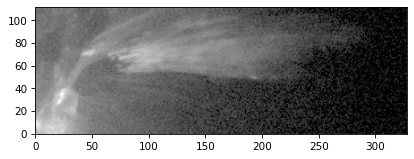

In [816]:
fig = plt.figure(dpi=75)
ax1 = fig.subplots(1, 1)
ax1.imshow(in_box, cmap='gray', origin="lower")
plt.show()

In [817]:
np.shape(in_box)

(112, 328)

In [818]:
a=np.sum(in_box,0)
np.shape(a)

(328,)

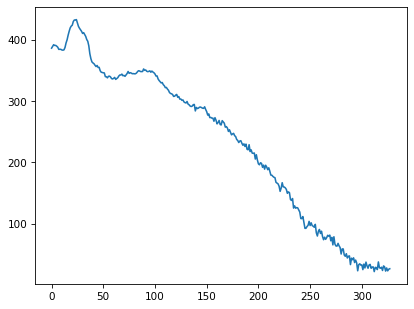

In [819]:
fig = plt.figure(dpi=75)
ax1 = fig.subplots(1, 1)
ax1.plot(a)
plt.show()

### Loop over all cutouts

Need to create a routine that will take one map, the box parameters, and do:
- extract the data and the box parameters in pixel
- rotate the image
- extract the data in the box and sum over the width

In [827]:
def extract_distance_line_from_box(cutout_map, box_center, box_width, box_length, box_angle, off_limb=False):
    
    ### Extract information from the map
    data_array = cutout_map.data
    pixel_scale = 0.5*(cutout_map.scale[0]+cutout_map.scale[1])
    
    ### Calculate box information in pixels
    rectangle_width_inpix = box_width/pixel_scale
    rectangle_length_inpix = box_length/pixel_scale
    rectangle_center_coord = SkyCoord(box_center[0], box_center[1], 
                                  obstime=cutout_map.date, ### the box will "follow" the data in time
                                  observer="earth", 
                                  frame="helioprojective")
    if off_limb:
        with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate, only_off_disk=True):
            px, py = aia_map.wcs.world_to_pixel(rectangle_center_coord)
    else:
        px, py = cutout_map.wcs.world_to_pixel(rectangle_center_coord)
    
    ### rotate data
    rotation_angle = box_angle
    rotated_data = ndimage.rotate(data_array, rotation_angle, reshape=True)
    
    ### calculate coordinates of the box in the rotated data
    new_coords = coordinates_in_rotated_frame(px,py,rotation_angle,data_array)
    rectangle_xx = new_coords[0] + 0.5*rectangle_length_inpix.value*np.array([-1,1])
    rectangle_yy = new_coords[1] + 0.5*rectangle_width_inpix.value*np.array([-1,1])
    
    ### extract data
    in_box = rotated_data[ int(rectangle_yy[0]):int(rectangle_yy[1]), int(rectangle_xx[0]):int(rectangle_xx[1])]
    in_box[np.isneginf(in_box)] = 0
    line = np.sum(in_box,0)
    
    ## create a array for the axis
    distance_axis = np.squeeze(np.arange(len(line))*u.pixel*pixel_scale)
    
    return line, distance_axis

In [829]:
line, distance = extract_distance_line_from_box(aia_map, selected_box.center(), 
                                                selected_box.width, selected_box.height, 
                                                selected_box.angle,
                                                off_limb=True)
np.shape(distance)

#distance

(251,)

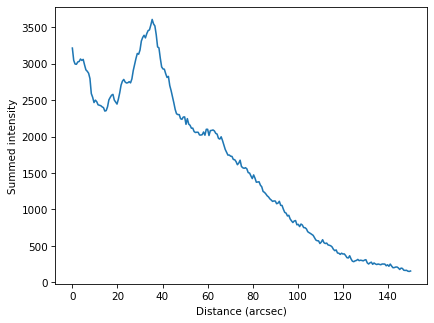

In [830]:
fig = plt.figure(dpi=75)
ax = fig.subplots(1, 1)
ax.plot(distance,line)
plt.xlabel("Distance (arcsec)")
plt.ylabel("Summed intensity")

plt.show()

In [831]:
time_distance = []
times = []
for file in files:
    aia_map = sunpy.map.Map(file)
    line, distance = extract_distance_line_from_box(aia_map, selected_box.center(), 
                                                selected_box.width, selected_box.height, 
                                                selected_box.angle,
                                                off_limb=True)
    time_distance.append(line)
    times.append(aia_map.date.to_datetime())

In [832]:
time_distance_array=np.array(time_distance).transpose()
time_array = np.array(times)

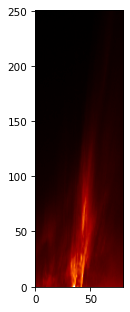

In [833]:
fig = plt.figure(dpi=75)
ax1 = fig.subplots(1, 1)
ax1.imshow(time_distance_array, origin="lower", cmap='sdoaia304')
plt.show()

In [834]:
import matplotlib.dates as mdates

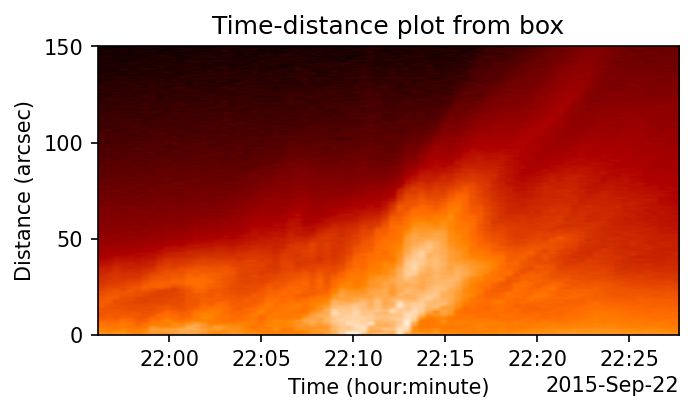

In [841]:
fig = plt.figure(dpi=150, figsize=(5,2.5))
ax = fig.subplots(1, 1)

x_lims = mdates.date2num(time_array)
y_lims = distance.value

ax.imshow(np.log(time_distance_array), origin="lower", cmap='sdoaia304', 
          extent = [x_lims[0], x_lims[-1],  y_lims[0], y_lims[-1]], 
          aspect='auto')

ax.set_title('Time-distance plot from box')
ax.set_xlabel('Time (hour:minute)')
ax.set_ylabel('Distance (arcsec)')

ax.xaxis_date()

locator = mdates.AutoDateLocator(minticks=3, maxticks=9)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.show()

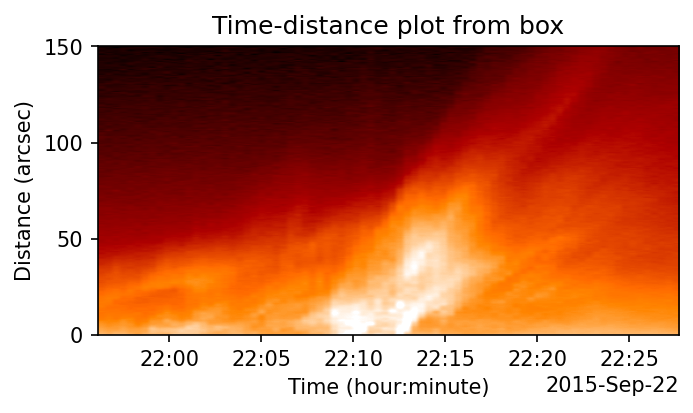

In [843]:
fig = plt.figure(dpi=150, figsize=(5,2.5))
ax = fig.subplots(1, 1)

x_lims = mdates.date2num(time_array)
y_lims = distance.value

ax.imshow(np.log(time_distance_array), origin="lower", cmap='sdoaia304', 
          extent = [x_lims[0], x_lims[-1],  y_lims[0], y_lims[-1]], 
          aspect='auto', 
          vmax=np.log(time_distance_array.max()/1.5))

ax.set_title('Time-distance plot from box')
ax.set_xlabel('Time (hour:minute)')
ax.set_ylabel('Distance (arcsec)')

ax.xaxis_date()

locator = mdates.AutoDateLocator(minticks=3, maxticks=9)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.show()

In [845]:
import datetime

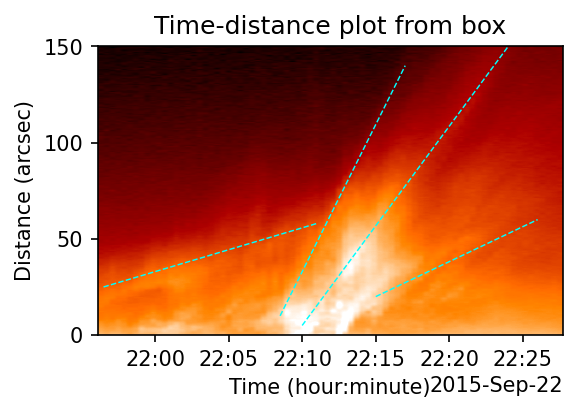

In [865]:
fig = plt.figure(dpi=150, figsize=(4,2.5))
ax = fig.subplots(1, 1)

x_lims = mdates.date2num(time_array)
y_lims = distance.value

ax.imshow(np.log(time_distance_array), origin="lower", cmap='sdoaia304', 
          extent = [x_lims[0], x_lims[-1],  y_lims[0], y_lims[-1]], 
          aspect='auto',
         vmax=np.log(time_distance_array.max()/1.5))

ax.set_title('Time-distance plot from box')
ax.set_xlabel('Time (hour:minute)')
ax.set_ylabel('Distance (arcsec)')

ax.xaxis_date()

locator = mdates.AutoDateLocator(minticks=3, maxticks=9)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

time1 = [datetime.datetime(2015,9,22,21,56,30),
         datetime.datetime(2015,9,22,22,11,0)]
dist1 = np.array( [25, 58] )
ax.plot(np.array(mdates.date2num(time1)), dist1, color='cyan', linestyle='dashed', linewidth=0.7)

time2 = [datetime.datetime(2015,9,22,22,8,30),
         datetime.datetime(2015,9,22,22,17,0)]
dist2 = np.array( [10, 140] )
ax.plot(np.array(mdates.date2num(time2)), dist2, color='cyan', linestyle='dashed', linewidth=0.7)

time3 = [datetime.datetime(2015,9,22,22,10,0),
         datetime.datetime(2015,9,22,22,24,0)]
dist3 = np.array( [5, 150] )
ax.plot(np.array(mdates.date2num(time3)), dist3, color='cyan', linestyle='dashed', linewidth=0.7)

time4 = [datetime.datetime(2015,9,22,22,15,0),
         datetime.datetime(2015,9,22,22,26,0)]
dist4 = np.array( [20, 60] )
ax.plot(np.array(mdates.date2num(time4)), dist4, color='cyan', linestyle='dashed', linewidth=0.7)

plt.show()

In [892]:
v1=(np.tan((dist1[1]-dist1[0])*u.arcsec)*1*u.au).to(u.km)/((time1[1]-time1[0]).total_seconds()*u.s)
v2=(np.tan((dist2[1]-dist2[0])*u.arcsec)*1*u.au).to(u.km)/((time2[1]-time2[0]).total_seconds()*u.s)
v3=(np.tan((dist3[1]-dist3[0])*u.arcsec)*1*u.au).to(u.km)/((time3[1]-time3[0]).total_seconds()*u.s)
v4=(np.tan((dist4[1]-dist4[0])*u.arcsec)*1*u.au).to(u.km)/((time4[1]-time4[0]).total_seconds()*u.s)
v1, v2, v3, v4

(<Quantity 27.51027741 km / s>,
 <Quantity 184.87301015 km / s>,
 <Quantity 125.19560021 km / s>,
 <Quantity 43.95581533 km / s>)

# Coronagraph data

Download data from JH

In [898]:
import hvpy
from sunpy.time import parse_time
from sunpy.util.config import get_and_create_download_dir

In [913]:
cor2_file = hvpy.save_file(hvpy.getJP2Image(parse_time('2015/09/22 22:14').datetime,
                                            hvpy.DataSource.COR2_A.value),
                           get_and_create_download_dir() + "/COR2.jp2", overwrite=True)
cor2_map = sunpy.map.Map(cor2_file)

In [919]:
print(cor2_map.observer_coordinate)

<SkyCoord (HeliographicStonyhurst: obstime=2015-09-22T10:36:21.005, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-170.45164, -6.7458423, 1.4430475e+11)>


In [915]:
projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=cor2_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=cor2_map.observer_coordinate,
                           rsun=aia_map.coordinate_frame.rsun)
projected_header = sunpy.map.make_fitswcs_header(aia_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(aia_map.scale),
                                                 instrument=aia_map.instrument,
                                                 wavelength=aia_map.wavelength)
# We use `assume_spherical_screen` to ensure that the off limb AIA pixels are reprojected
# otherwise it will only be the on disk pixels that are reprojected.
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
    aia_reprojected = aia_map.reproject_to(projected_header)

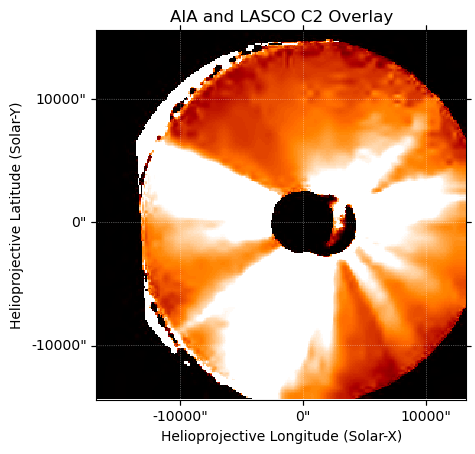

In [917]:
fig = plt.figure()
ax = fig.add_subplot(projection=cor2_map)
cor2_map.plot(axes=ax)
#aia_reprojected.plot(axes=ax, clip_interval=(1, 99.9)*u.percent, autoalign=True)
ax.set_title("AIA and LASCO C2 Overlay")

plt.show()

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


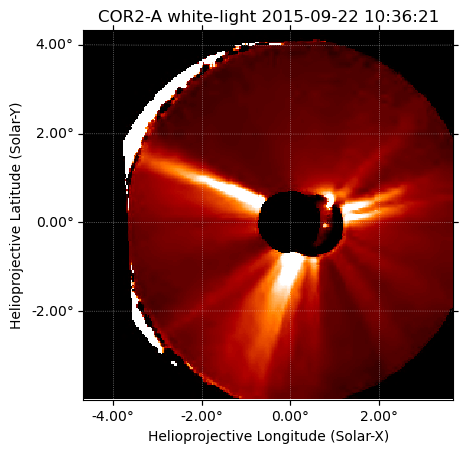

In [914]:
fig = plt.figure()
ax = fig.add_subplot(projection=cor2_map)

# Let's tweak the axis to show in degrees instead of arcsec
lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

cor2_map.plot(axes=ax, vmin=0, vmax=600)

plt.show()

Try download from https://lasco-www.nrl.navy.mil/index.php?p=get_data

In [927]:
data_lasco = 'C://Users//sophie.musset//data//LASCO//C2//2015//09//22//22563836.fts'
data_lasco=  'C://Users//sophie.musset//data//LASCO//C2//2015//09//22//22563836.fts'

In [928]:
lasco_map = sunpy.map.Map(data_lasco)

ValueError: Did not find any files at C:\Users\sophie.musset\data\LASCO\C2\2015\09\22\22563836.fts

# Various tests

In [403]:
vars(Jet_clusters[jetid].jets[0])

{'subject': 74635323,
 'start': array([1111.81494141,  878.27174886]),
 'end': array([1097.75927734,  885.64715576]),
 'box': <POLYGON ((1216.122 973.419, 1178.512 1007.697, 1061.207 878.987, 1098.818 8...>,
 'cluster_values': array([1113.22096071,  839.13064145,   50.88740832,  174.14544095,
           2.40252113]),
 'box_extracts': {'x': [], 'y': [], 'w': [], 'h': [], 'a': []},
 'start_extracts': {'x': [], 'y': []},
 'end_extracts': {'x': [], 'y': []},
 'base_points': array([[1098.81760558,  844.70948118],
        [1061.20701209,  878.98733966]]),
 'height_points': array([[1061.20701209,  878.98733966],
        [1178.51172415, 1007.69724267]]),
 'angle': 2.4025211308317003,
 'height': 174.1454409493618,
 'width': 50.887408319418704,
 'time': numpy.datetime64('2015-09-22T22:11:42.000000'),
 'sigma': 0.4241935943266853,
 'solar_cluster_values': array([ 906.249     , -316.644     ,   16.25582   ,   55.62879228,
           2.40252113]),
 'solar_H': 55.62879227522375,
 'solar_H_sig': arra

In [407]:
Jet_clusters[jetid].jets[0].start

array([1111.81494141,  878.27174886])

In [195]:
Jet_clusters[0].jets[0].end

array([1024.50595093,  505.61196899])

In [221]:
Jet_clusters[0].jets[0].box_extracts

{'x': [], 'y': [], 'w': [], 'h': [], 'a': []}

In [ ]:
Jet_clusters[0].jets[0].box_extracts['x']